# Product Recommendation Systems

## Domain : 
E-Commerce

## Context :
Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

## Data :

### Source
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.

### Description
Data columns- userId, productId, ratings and timestamp.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; 
warnings.filterwarnings('ignore')

C:\Users\utkarsh_khamgaonkar\Documents\Personal\Research\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Read the data set
electronics_data = pd.read_csv('ratings_Electronics.csv',names=['userId', 'productId','rating','timeStamp'])
electronics_data.head()

,userId,productId,rating,timeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### Exploratory Data Analysis

In [3]:
electronics_data.shape

(7824482, 4)

In [4]:
#Taking subset of the dataset and removing timeStamp column
electronics_data=electronics_data.iloc[:1048576,0:3]

In [5]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
rating       float64
dtype: object

In [6]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
userId       1048576 non-null object
productId    1048576 non-null object
rating       1048576 non-null float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [7]:
# Check for missing values in the subset
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
rating       0
dtype: int64


In [8]:
# Hence, there are no missing values in the subset of given data.

In [9]:
# Five point summary 
electronics_data.describe()['rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.rating.min()))
print('Maximum rating is: %d' %(electronics_data.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


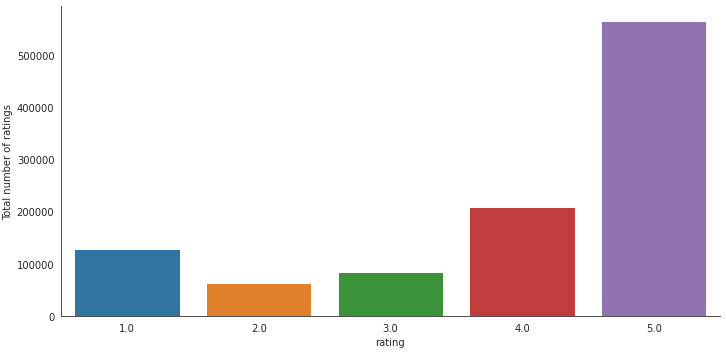

In [11]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [12]:
# Majority of people has given the rating of 5, followed by 4 and 1.

In [13]:
# Unique Users and products
print("Total data ")
print("-"*50)
print("Total no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------
Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


#### Analyzing the rating

In [14]:
#Analysis of rating given by the user 
electronics_data['rating'] = electronics_data['rating'].apply(np.int64)
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: rating, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

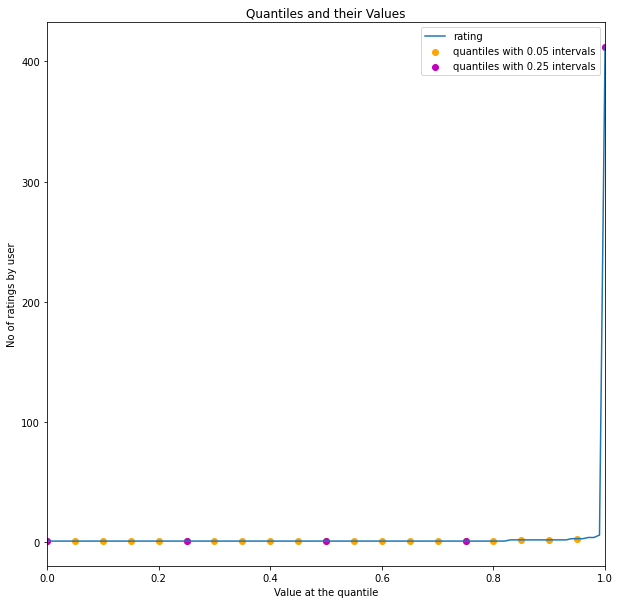

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.5 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
print('No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )

No of rated product more than 50 per user : 38



## Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [19]:
#Getting the new dataframe which contains users who has given 50 or more ratings
users_50ormore_ratings=electronics_data.groupby("productId").filter(lambda x:x['rating'].count() >=50)

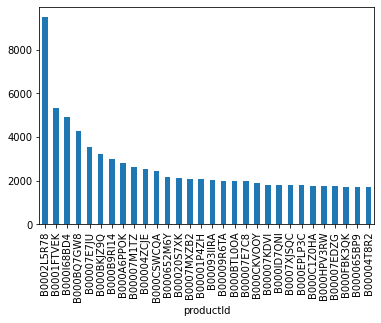

In [20]:
no_of_ratings_per_product = users_50ormore_ratings.groupby(by='productId')['rating'].count().sort_values(ascending=False)
no_of_ratings_per_product.head(30).plot(kind = "bar")

#### Observation :
<ol>
<li>The above graph gives us the most popular products (arranged in descending order) sold by the business.</li>
<li>For eaxmple, product, ID # B0002L5R78 has over 9000 reviews, the next most popular product, ID # B0001FTVEK has over 5000 reviews etc.</li>
</ol>

In [21]:
#Average rating of the product 
users_50ormore_ratings.groupby('productId')['rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: rating, dtype: float64

In [22]:
users_50ormore_ratings.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: rating, dtype: float64

In [23]:
#Total no of rating for product
users_50ormore_ratings.groupby('productId')['rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: rating, dtype: int64

In [24]:
ratings_mean_count = pd.DataFrame(users_50ormore_ratings.groupby('productId')['rating'].mean())

In [25]:
ratings_mean_count['rating_counts'] = pd.DataFrame(users_50ormore_ratings.groupby('productId')['rating'].count())

In [26]:
ratings_mean_count.sort_values(by='rating_counts',ascending=False).head()

,rating,rating_counts
productId,,
B0002L5R78,4.448614,9487
B0001FTVEK,4.007109,5345
B000I68BD4,3.501530,4903
B000BQ7GW8,4.553216,4275
B00007E7JU,4.565995,3523


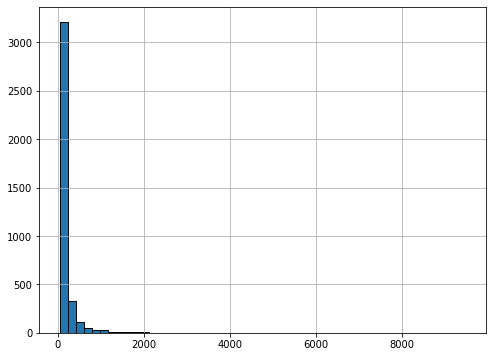

In [27]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

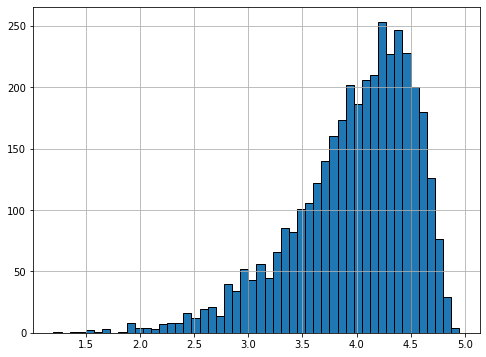

In [28]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

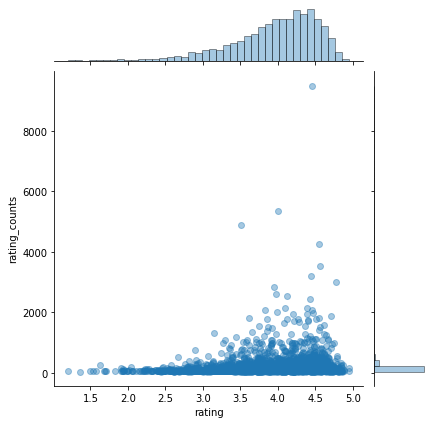

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

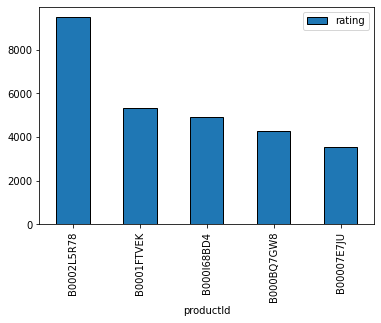

In [30]:
popular_products = pd.DataFrame(users_50ormore_ratings.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head().plot(kind = "bar")

#### Conclusion :
<ul>
    <li>These are the top 5 recommendadtions for an electronic product based on their popularity.</li>
</ul>

## Collaborative filtering

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [31]:
# Import necessary libraries.
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [32]:
#Reading the dataset
reader = Reader()
data = Dataset.load_from_df(users_50ormore_ratings,reader)

In [33]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [34]:
# Item-Item Collaborative Filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [35]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [36]:
test_pred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0, est=

In [37]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

In [38]:
# Model-based collaborative filtering system
users_50ormore_ratings_top10000=users_50ormore_ratings.head(10000)
ratings_utility_matrix = users_50ormore_ratings_top10000.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)
ratings_utility_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Observation :
<ul>
    <li>As expected, the utility matrix obtained above is sparce, the unknown values are filled up with 0.</li>
</ul>

In [39]:
ratings_utility_matrix.shape

(9832, 76)

In [40]:
# Transposing the matrix
X = ratings_utility_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X.shape

(76, 9832)

In [42]:
X1 = X

In [43]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [44]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [46]:
# Isolating Product ID # B00000K135 from the Correlation Matrix assuming the customer buys Product ID # B00000K135 (randomly chosen).
X.index[75]

'B00000K135'

In [47]:
# Index # of product ID purchased by customer
i = "B00000K135"
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [48]:
# Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [50]:
# Recommending top 5 highly correlated products in sequence
Recommend = list(X.index[correlation_product_ID > 0.85])
# Removes the item already bought by the customer
Recommend.remove(i) 
Recommend[0:5]

['B00000J05A', 'B00000J1U8', 'B00000J1UQ', 'B00000JBHP', 'B00000JDHV']

## Conclusion :
<ul>
    <li>Here are the top 5 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.</li>
</ul>